<a href="https://colab.research.google.com/github/Putradhika23/Forecasting_emergency_department/blob/main/peramalanLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import modul standar

In [ ]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import dataset

In [ ]:
df = read_csv('/content/drive/My Drive/Colab Notebooks/dataset/data_arrival_igd.csv')
series = df['ARRIVAL']
df.head()

,DATE,ARRIVAL
0,2020-03-01,72
1,2020-03-02,88
2,2020-03-03,75
3,2020-03-04,81
4,2020-03-05,75


melihat informasi singkat dari dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     731 non-null    object
 1   ARRIVAL  731 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.5+ KB


In [ ]:
# merubah tipe data object to datetime
df['DATE']=df['DATE'].astype('datetime64')

print(df.dtypes)

DATE       datetime64[ns]
ARRIVAL             int64
dtype: object


In [ ]:
print("waktu terawal dari kolom datetime adalah", df['DATE'].min())
df.head()

waktu terawal dari kolom datetime adalah 2020-03-01 00:00:00


,DATE,ARRIVAL
0,2020-03-01,72
1,2020-03-02,88
2,2020-03-03,75
3,2020-03-04,81
4,2020-03-05,75


**Plot data**

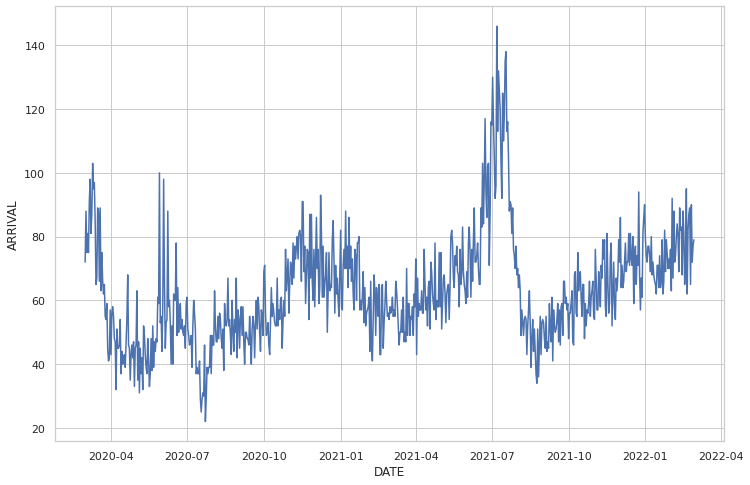

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='DATE',y='ARRIVAL')

melihat statistik deskriptif dari data

In [ ]:
df.describe()

,ARRIVAL
count,731.000000
mean,63.119015
std,17.189701
min,22.000000
25%,52.000000
50%,61.000000
75%,72.000000
max,146.000000


Split Data

In [ ]:
train_size= int(len(df)*0.8)
train = df[:train_size]
test =df[train_size:].reset_index(drop=True)

Feature Scalling menggunakan MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['ARRIVAL']])

train['scaled']=scaler.transform(train[['ARRIVAL']])
test['scaled']=scaler.transform(test[['ARRIVAL']])

In [ ]:
test.head(800)

,DATE,ARRIVAL,scaled
0,2021-10-05,63,0.330645
1,2021-10-06,47,0.201613
2,2021-10-07,46,0.193548
3,2021-10-08,68,0.370968
4,2021-10-09,69,0.379032
...,...,...,...
142,2022-02-24,65,0.346774
143,2022-02-25,90,0.548387
144,2022-02-26,72,0.403226
145,2022-02-27,77,0.443548


membuat fungsi sliding window

In [ ]:
def sliding_window(data, window_size):
    sub_seq, next_values =[],[]
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    x=np.stack(sub_seq)
    y=np.array(next_values)
    return x,y

In [ ]:
window_size = 30

x_train, y_train = sliding_window(train[['scaled']].values, window_size)
x_test, y_test = sliding_window(test[['scaled']].values, window_size)

data input lstm harus 3D: [samples, timesteps, features]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(554, 30, 1) (554, 1)
(117, 30, 1) (117, 1)


parameter membuat lstm layer:
1. units: menentukan banyaknya LSTM unit
2. input_shape: menentukan ukuran timesteps dan features, diperlukan pada layer pertama
3. return_sequences: jika layer berikutnya berupa LSTM layer maka return_sequences=True

Membuat Model Forecasting Menggunakan LSTM

1. Import modul

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2. Membuat fungsi model forecasting menggunakan LSTM

Fungsi model yang akan dibuat terdiri


*   LSTM layer dengan input_shape= (window_size, 1)
*   Dense layer dengan 32 neuron dengan fungsi Relu
*   Dropout antara Dense Layer dan Dense output layer
*   Dense output layer dengan 1 neuron
*   loss function menggunakan MSE
*   optimizer yang digunakan adalah adam
*   metric yang digunakan adalah MAE

Parameter yang dijadikan sebagai input dari fungsi tersebut adalah


*   LSTM_unit:banyaknya LSTM unit (default=64)
*   dropout: persentase dropout (default=0.2)

In [ ]:
def create_model(LSTM_unit=128, dropout=0.2):
    # create model
    model = Sequential()
    model.add(LSTM(units=LSTM_unit, input_shape=(window_size,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # compile model
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

3. Membuat Model

*   LSTM_unit=[16,32,64,128]
*   Dropout=[0.1,0.2]

menggunakan early stopping pada saat proses training



In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

In [ ]:
#early Stopping
#es = EarlyStopping(monitor='val_loss', mode='min', patience= 5, verbose= 0)
#callbacks=[es],
#create model
model = KerasRegressor(build_fn=create_model, epochs=50, validation_split=0.1, batch_size=32,  verbose=1)

#define the grid search parameters
LSTM_unit = [32,64]
dropout=[0.1,0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

4. Membuat variabel GridSearchCV

Variabel GridSearchCV dibuat dengan memasukan beberapa parameter yaitu:

*   Estimator: model yang ingin dilakukan GridSearchCV
*   param_grid: parameter yang ingin diuji
*   n_jobs: jumlah pekerjaan untuk dijalankan secara paralel
*   cv: banyaknya k-fold cross validation





In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

5. Training model dengan GridSearchCV

In [ ]:
grid_result = grid.fit(x_train, y_train)

Epoch 1/50
16/16 [==============================] - 3s 54ms/step - loss: 0.0534 - mae: 0.1880 - val_loss: 0.0037 - val_mae: 0.0480
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0127 - mae: 0.0908 - val_loss: 0.0038 - val_mae: 0.0484
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0107 - mae: 0.0749 - val_loss: 0.0037 - val_mae: 0.0484
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0093 - mae: 0.0721 - val_loss: 0.0033 - val_mae: 0.0461
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0087 - mae: 0.0694 - val_loss: 0.0035 - val_mae: 0.0472
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0086 - mae: 0.0695 - val_loss: 0.0029 - val_mae: 0.0436
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0081 - mae: 0.0683 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0080 - m

6. Melihat hasil parameter terbaik

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.006547 using {'LSTM_unit': 32, 'dropout': 0.1}
-0.006547 (0.002620) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.006567 (0.002624) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.006660 (0.002506) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.006597 (0.002734) with: {'LSTM_unit': 64, 'dropout': 0.2}


grafik loss function MSE dan metric MAE terhadap epoch untuk melihat performa model

In [ ]:
history = best_model.history

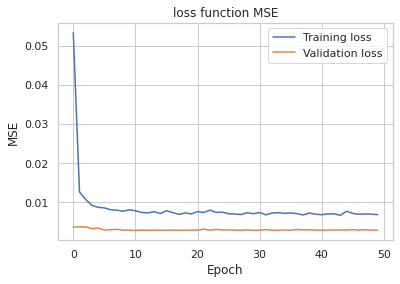

In [ ]:
# grafik Loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

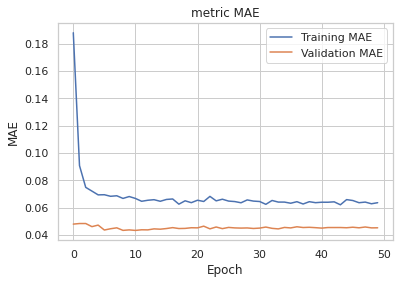

In [ ]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

7. Evaluasi Model

Melakukan prediksi pada data train dan data test

In [ ]:
# prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(x_train))
true_train = scaler.inverse_transform(y_train)

#prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(x_test))
true_test = scaler.inverse_transform(y_test)

In [ ]:
print("\n\nTrain Predict (10 pertama)= ",predict_test[:10])



Train Predict (10 pertama)=  [[62.878468]
 [62.10498 ]
 [61.352947]
 [62.78849 ]
 [63.234745]
 [62.542408]
 [64.17151 ]
 [64.90299 ]
 [67.73155 ]
 [69.12765 ]]


In [ ]:
my_dict = {'Train Predictions':predict_test,'Train Actual':true_test}
pd.DataFrame([my_dict])

,Train Predictions,Train Actual
0,"[[62.878468], [62.10498], [61.352947], [62.788...","[[57.0], [57.0], [69.0], [64.0], [58.0], [71.0..."


In [ ]:
print(np.array(predict_test).reshape(-1,1))

[[62.878468]
 [62.10498 ]
 [61.352947]
 [62.78849 ]
 [63.234745]
 [62.542408]
 [64.17151 ]
 [64.90299 ]
 [67.73155 ]
 [69.12765 ]
 [71.42417 ]
 [69.612305]
 [67.336105]
 [69.89996 ]
 [69.49525 ]
 [67.27925 ]
 [65.74893 ]
 [67.08466 ]
 [69.006584]
 [66.0733  ]
 [65.20516 ]
 [66.23708 ]
 [64.70192 ]
 [62.582592]
 [63.064728]
 [62.829445]
 [63.548492]
 [66.16751 ]
 [67.29466 ]
 [70.89479 ]
 [70.10188 ]
 [70.57438 ]
 [69.68622 ]
 [69.235565]
 [69.86309 ]
 [71.475334]
 [71.303345]
 [71.63275 ]
 [71.92018 ]
 [73.75806 ]
 [73.56847 ]
 [75.11207 ]
 [74.99494 ]
 [74.53978 ]
 [75.67813 ]
 [72.806595]
 [72.91362 ]
 [73.593636]
 [72.024895]
 [72.15834 ]
 [71.77879 ]
 [75.670906]
 [74.408646]
 [71.23492 ]
 [70.215225]
 [68.211754]
 [70.09957 ]
 [72.784485]
 [75.95332 ]
 [76.84037 ]
 [76.61099 ]
 [76.00861 ]
 [76.31402 ]
 [76.56538 ]
 [76.22783 ]
 [74.9881  ]
 [75.82021 ]
 [74.37744 ]
 [73.78582 ]
 [72.55065 ]
 [71.0438  ]
 [69.54764 ]
 [67.67284 ]
 [67.69829 ]
 [67.81901 ]
 [66.65462 ]
 [67.531   ]

In [ ]:
df2 = np.array(predict_test).reshape(-1,1)
print(df2.shape)

(117, 1)


In [ ]:
df2

array([[62.878468],
       [62.10498 ],
       [61.352947],
       [62.78849 ],
       [63.234745],
       [62.542408],
       [64.17151 ],
       [64.90299 ],
       [67.73155 ],
       [69.12765 ],
       [71.42417 ],
       [69.612305],
       [67.336105],
       [69.89996 ],
       [69.49525 ],
       [67.27925 ],
       [65.74893 ],
       [67.08466 ],
       [69.006584],
       [66.0733  ],
       [65.20516 ],
       [66.23708 ],
       [64.70192 ],
       [62.582592],
       [63.064728],
       [62.829445],
       [63.548492],
       [66.16751 ],
       [67.29466 ],
       [70.89479 ],
       [70.10188 ],
       [70.57438 ],
       [69.68622 ],
       [69.235565],
       [69.86309 ],
       [71.475334],
       [71.303345],
       [71.63275 ],
       [71.92018 ],
       [73.75806 ],
       [73.56847 ],
       [75.11207 ],
       [74.99494 ],
       [74.53978 ],
       [75.67813 ],
       [72.806595],
       [72.91362 ],
       [73.593636],
       [72.024895],
       [72.15834 ],


In [ ]:
for i,a in enumerate(predict_train):
    str_train = str(a)
    str_train= str_train.replace("[", "").replace("]", "")
    float_train=float(str_train[:8])
    list_float_train.append(float_train)

ValueError: ignored

setelah melakukan prediksi berulah kita melakukan evaluasi terhadap nilai prediksi tersebut menggunakan metric yang digunakan yaitu MAE

In [ ]:
#MAE data train
mae_train = np.mean(np.abs(true_train-predict_train))
print('MAE data train sebesar', mae_train)

#MSE data train
mse_train = mean_squared_error(true_train, predict_train)
print('MSE data train sebesar: %.4f ' % (mse_train))

#RMSE data train
rmse_train = math.sqrt(mean_squared_error(true_train, predict_train))
print('RMSE data train sebesar: %.4f ' % (rmse_train))

#MAPE data train
mape_train = np.mean(abs((true_train-predict_train)/true_train))
print('MAPE data train sebesar: %.4f ' % (mape_train))

#MAE data test
mae_test = np.mean(np.abs(true_test-predict_test))
print('MAE data test sebesar', mae_test)

#MSE data train
mse_test = mean_squared_error(true_test, predict_test)
print('MSE data test sebesar: %.4f ' % (mse_test))

#RMSE data test
rmse_test = math.sqrt(mean_squared_error(true_test, predict_test))
print('RMSE data test sebesar: %.4f ' % (rmse_test))

#MAPE data train
mape_test = np.mean(np.abs((true_test-predict_test)/true_test))
print('MAPE data test sebesar: %.4f ' % (mape_test))

MAE data train sebesar 7.310506207848284
MSE data train sebesar: 90.6153 
RMSE data train sebesar: 9.5192 
MAPE data train sebesar: 0.1257 
MAE data test sebesar 7.147863436967898
MSE data test sebesar: 78.9951 
RMSE data test sebesar: 8.8879 
MAPE data test sebesar: 0.1000 


boxplot dari nilai error mutlak

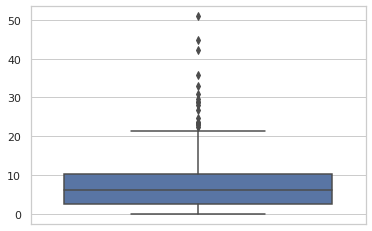

In [ ]:
abs_error_train = np.abs(true_train-predict_train)
sns.boxplot(y=abs_error_train)

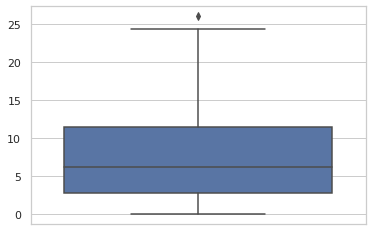

In [ ]:
abs_error_test = np.abs(true_test-predict_test)
sns.boxplot(y=abs_error_test)

melihat range data

In [ ]:
print("range data train", true_train.max()-true_train.min())
print("range data test", true_test.max()-true_test.min())

range data train 124.0
range data test 43.0


Plot prediksi data train

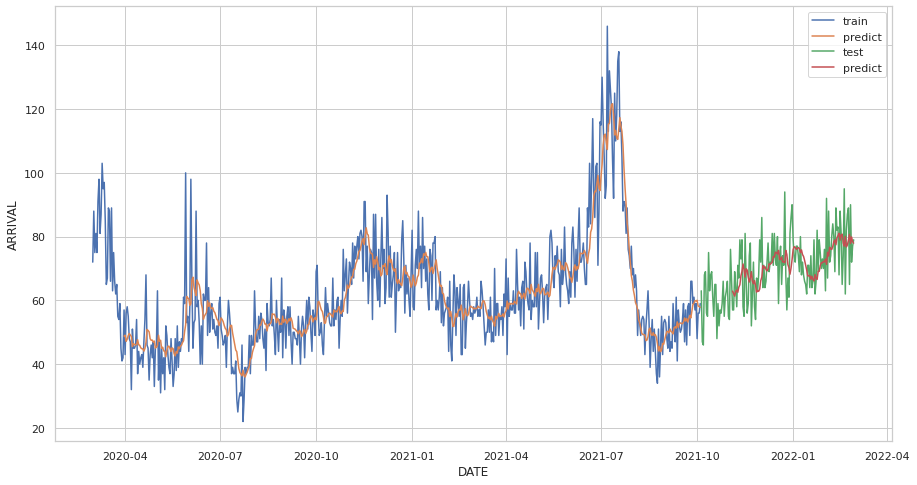

In [ ]:
train['predict']= np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]
test['predict']= np.nan
test['predict'][-len(predict_test):]= predict_test[:,0]

plt.figure(figsize=(15,8))

sns.lineplot(data=train, x='DATE', y='ARRIVAL', label = 'train')
sns.lineplot(data=train, x='DATE', y='predict', label = 'predict')
sns.lineplot(data=test, x='DATE', y='ARRIVAL', label = 'test')
sns.lineplot(data=test, x='DATE', y='predict', label = 'predict') 


plot prediksi data train

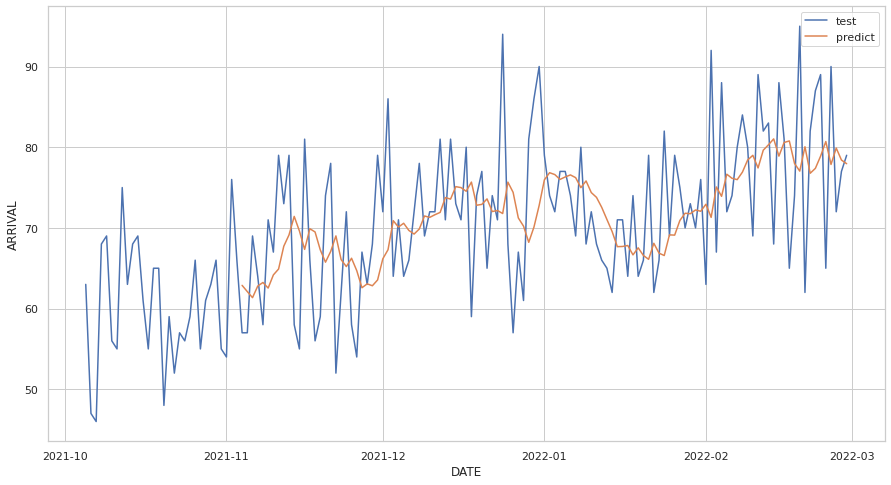

In [ ]:
test['predict']= np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='DATE', y='ARRIVAL', label = 'test')
sns.lineplot(data=test, x='DATE', y='predict', label = 'predict') 

plot prediksi data test sebulan terakhir

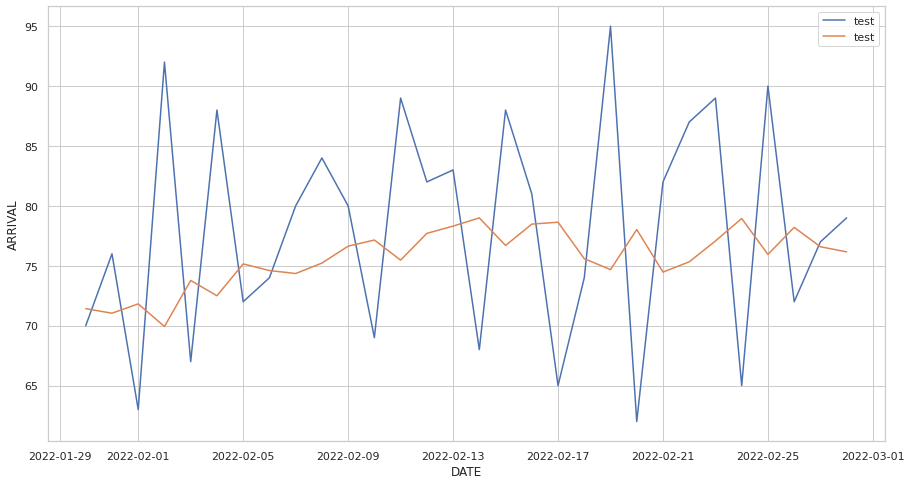

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-30:], x='DATE', y='ARRIVAL', label='test')
sns.lineplot(data=test[-30:], x='DATE', y='predict', label='test')

Print angka peramalan

In [ ]:
train_predictions = best_model.predict(x_train).flatten()
true_train = scaler.inverse_transform(y_train)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions})
train_results

,Train Predictions
0,0.211091
1,0.212708
2,0.198045
3,0.202932
4,0.211626
...,...
549,0.302085
550,0.304534
551,0.291356
552,0.290157


In [ ]:
train_predictions = best_model.predict(x_train).flatten()
train_predictdict = scaler.inverse_transform(train_predictions)
true_train = scaler.inverse_transform(y_train)
train_results = pd.DataFrame(data={'Train Predictions':train_predictdict, 'Train Actual':true_train})
train_results

ValueError: ignored

In [ ]:
test_predictions = best_model.predict(x_test).flatten()
true_test = scaler.inverse_transform(y_test)
test_results = pd.DataFrame(data={'Train Predictions':test_predictions})
test_results

,Train Predictions
0,0.323275
1,0.318315
2,0.314505
3,0.327017
4,0.330146
...,...
112,0.457598
113,0.434734
114,0.452011
115,0.439515
